In [11]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [12]:
def compute_pairwise_cosine_similarity(epoch: int, layer_name: str, base_path: str):
    layer_dir = os.path.join(
        base_path,
        f"grad_info_per_epoch",
        f"epoch{epoch}",
        layer_name
    )

    grad_list = []
    filenames = sorted([
        f for f in os.listdir(layer_dir) if f.endswith(".pt")
    ])

    for fname in filenames:
        grad = torch.load(os.path.join(layer_dir, fname))  # [D]
        grad_list.append(grad)

    grads = torch.stack(grad_list)  # [T, D]
    T = grads.size(0)

    pairwise_sims = []
    for i in range(T):
        for j in range(i + 1, T):
            sim = F.cosine_similarity(grads[i], grads[j], dim=0).item()
            pairwise_sims.append(sim)

    avg_pairwise_sim = sum(pairwise_sims) / len(pairwise_sims)
    
    print(f"{layer_name} (epoch {epoch}): Avg pairwise cosine similarity = {avg_pairwise_sim:.4f}")
    
    return avg_pairwise_sim


def compute_pairwise_cosine_similarity_over_epochs(layer_name: str, base_path: str, epoch_list: list):
    results = {}
    for epoch in epoch_list:
        try:
            avg_sim = compute_pairwise_cosine_similarity(epoch, layer_name, base_path)
            results[epoch] = avg_sim
        except Exception as e:
            print(f"[Warning] Epoch {epoch} failed: {e}")
    return results


def plot_pairwise_cosine_similarity_comparison_subplots(maml_base_path: str, our_base_path: str, epoch_list: list):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    num_layers = len(layer_names)
    nrows = (num_layers + 1) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 3 * nrows))
    axes = axes.flatten()

    for idx, layer_name in enumerate(layer_names):
        ax = axes[idx]

        # MAML
        maml_results = compute_pairwise_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=maml_base_path,
            epoch_list=epoch_list
        )
        sorted_epochs = sorted(maml_results.keys())
        maml_values = [maml_results[ep] for ep in sorted_epochs]
        ax.plot(sorted_epochs, maml_values, label="MAML", linestyle='dashed')

        # OURS
        our_results = compute_pairwise_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=our_base_path,
            epoch_list=epoch_list
        )
        our_values = [our_results[ep] for ep in sorted_epochs]
        ax.plot(sorted_epochs, our_values, label="OURS", linestyle='solid')

        ax.set_title(layer_name, fontsize=10)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Pairwise Cosine Similarity")
        ax.set_xticks(sorted(epoch_list))
        # ax.set_ylim(-1, 1)
        ax.grid(True)
        ax.legend(fontsize=8)

    # 여분 subplot 제거
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
def plot_and_save_pairwise_cos_sim_layerwise_individual(
    maml_base_path: str,
    our_base_path: str,
    epoch_list: list,
    save_dir: str = "gradient/pairwise_cos_sim"
):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    save_dir = os.path.normpath(save_dir)
    os.makedirs(save_dir, exist_ok=True)

    for layer_name in layer_names:
        plt.figure(figsize=(8, 5))

        # MAML
        maml_results = compute_pairwise_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=maml_base_path,
            epoch_list=epoch_list
        )
        sorted_epochs = sorted(maml_results.keys())
        maml_values = [maml_results[ep] for ep in sorted_epochs]
        plt.plot(sorted_epochs, maml_values, label="MAML", linestyle='dashed')

        # OURS
        our_results = compute_pairwise_cosine_similarity_over_epochs(
            layer_name=layer_name,
            base_path=our_base_path,
            epoch_list=epoch_list
        )
        our_values = [our_results[ep] for ep in sorted_epochs]
        plt.plot(sorted_epochs, our_values, label="OURS", linestyle='solid')

        # 그래프 설정
        plt.title(f"Pairwise Cosine Similarity - {layer_name}", fontsize=12)
        plt.xlabel("Epoch")
        plt.ylabel("Pairwise Cosine Similarity")
        plt.xticks(sorted(epoch_list))
        # plt.ylim(-1, 1)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        # 저장
        filename = f"{layer_name}_pairwise_cosine_similarity.png"
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path, dpi=300)
        plt.close()

        print(f"[Saved] {save_path}")

layer_layer_dict_conv0_conv_weight (epoch 0): Avg pairwise cosine similarity = 0.0008
layer_layer_dict_conv0_conv_weight (epoch 1): Avg pairwise cosine similarity = 0.0006
layer_layer_dict_conv0_conv_weight (epoch 0): Avg pairwise cosine similarity = 0.0046
layer_layer_dict_conv0_conv_weight (epoch 1): Avg pairwise cosine similarity = 0.0012


KeyboardInterrupt: 

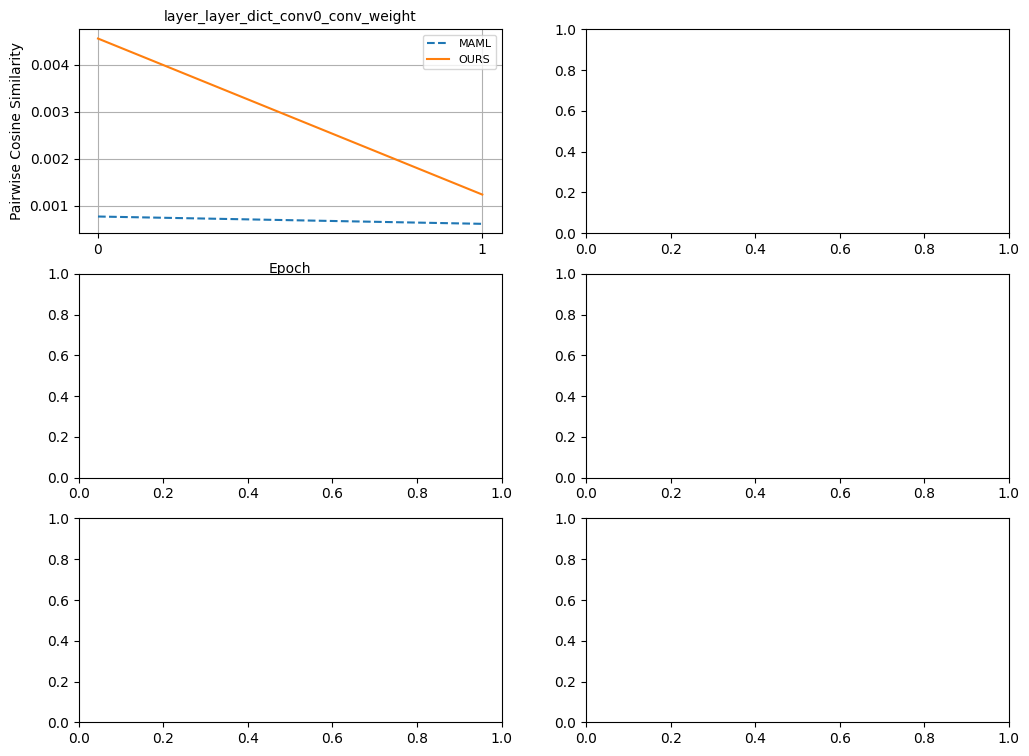

In [13]:
maml_base_path = "../MAML_5way_5shot_filter64_miniImagenet"
our_base_path = "../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet"
epoch_list = list(range(0, 2))

plot_pairwise_cosine_similarity_comparison_subplots(maml_base_path, our_base_path, epoch_list)

In [ ]:
plot_and_save_pairwise_cos_sim_layerwise_individual(maml_base_path, our_base_path, epoch_list)